# Hyperspectral Data Investigation Notebook

In [ ]:
"""
The following code was developed by:

Edward Saunders, es758@cam.ac.uk
George Lewis, grl31@cam.ac.uk

This notebook contains the driving code for investigating hyperspectral data sets. Some unfinished analysis tools are also included.
The code was developed for the NanoDTC mini 1 project "A multidimensional investigation into the growth conditions of halide perovskites".

08/02/2022
"""

In [1]:
import hyperspy.api as hs                 # hyperspectral data processing and some useful image viewing
import h5py                               # to handle .h5 files
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2                                # Image analysis
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from datetime import datetime             # For easily parsing timestamps
import warnings
warnings.filterwarnings("ignore")         # Attempt to remove some unnecessary pyplot warnings
from scipy.optimize import curve_fit
import pandas as pd
from pathlib import Path
import optical_image_functions as oif
import hyperspectral_image_functions as hsif

Set folder location of data.

In [40]:
#folder=r'C:\Users\Edward\University of Cambridge\Alice Dearle - mini1 hyper-perov\example 2 hyperspectral 60deg\090321\\'
folder=r'C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\example 2 hyperspectral\090321\\'
# folder=r'C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\hyperspectral 70deg\\'
# folder=r'E:\200122\\'

fpaths = oif.get_filepaths(folder)

The hyperspectral microscope in MRC has software which outputs 2 files per time step, one being a rectified image stack which is what is wanted. The code below extracts the file paths for these rectified images alone.

In [41]:
rectified_fpaths = []
for fpath in fpaths:
    if fpath[-9:] == "(1)(1).h5":
        rectified_fpaths.append(fpath)

Inspect some of the properties of each image stack, and extract the pixel size.

In [42]:
fpath=rectified_fpaths[0]
print(fpath)
f = h5py.File(fpath,'r')
# Extract the image
print("Number of wavelengths per time step", len(f['Cube/Wavelength']))
pixel_size = oif.get_pixel_size(fpath)
print("Pixel size is", pixel_size, "µm/pixel")

C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\example 2 hyperspectral\090321\\Untitled(1)(1).h5
Number of wavelengths per time step 26
Pixel size is 0.325 µm/pixel


For further information of what each h5py file contains.

In [31]:
# oif.get_h5py_contents(fpath)

## Extract and Shape Data

From the appropriate file path list, extract most of the information we will need in a nice form. 

In [43]:
images_2D, ts, wavelengths = hsif.extract_h5py_hyperspec_data(rectified_fpaths)

Create a set of the data as 1D images.

In [44]:
images_1D = np.array([hsif.convert_signal_dimensions(image_stack) for image_stack in images_2D])

### Inspecting the Data

Be wary of operating on signal data directly without taking copies. Safer to create a copy first if going to do processing outside of hyperspy tools.

2D Signal Images:

In [8]:
%matplotlib qt

fpath=rectified_fpaths[0] # just looking at first image
test_image_stack = hsif.extract_h5py_image_stack(fpath)
test_image_stack.plot(navigator='auto')
test_image_stack.axes_manager

<Axes manager, axes: (26|1024, 1024)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
          lambda |     26 |      0 | 5.1e+02 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |   1024 |        |       0 |    0.33 |     µm 
               y |   1024 |        |       0 |    0.33 |     µm

(26, 1024, 1024)
(1024, 1024)
(1024, 1024)


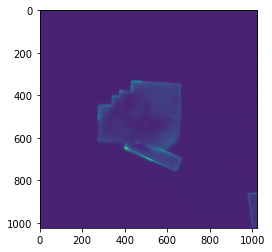

In [9]:
%matplotlib inline
print(test_image_stack.data.shape)
print(test_image_stack.data[7][:][:].shape)
test=test_image_stack.data[24][:][:]
print(test.shape)
plt.imshow(test)

1D signal images:

In [10]:
%matplotlib qt

slider = False

fpath=rectified_fpaths[10] # just looking at first image
test_image_stack = hsif.extract_h5py_image_stack(fpath)
im_1d = test_image_stack.transpose()

if slider == False:
    #im_1d=im_1d.rebin(scale=[10,10,1]) # bin image so that can actually see the navigator frame to inspect the data
    im_1d.plot(navigator='auto', autoscale='') # autoscale setting just allows easier comparison by preventing rescaling
elif slider == True:
    im_1d.plot(navigator='slider')
im_1d.axes_manager

<Axes manager, axes: (1024, 1024|26)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |   1024 |      0 |       0 |    0.33 |     µm 
               y |   1024 |      0 |       0 |    0.33 |     µm 
---------------- | ------ | ------ | ------- | ------- | ------ 
          lambda |     26 |        | 5.1e+02 |       2 |     nm

(102, 102, 26)
(102, 26)
(102, 102)


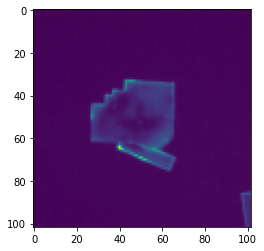

In [14]:
%matplotlib inline
print(im_1d.data.shape)
print(im_1d.data[0].shape)
test=im_1d.data[:][:]
print(test[:,:,0].shape)
plt.imshow(test[:,:,24])

## Peak Wavelength Shift

In [11]:
def click_point_detection(im):
    """ 
    Convenient function for selecting points.
    Opens user input to manually click out points (in index positions) to extract coordinates of interest.
    Currently have set max as 10 points.
    """
    # Show image
    plt.imshow(im,cmap='Greys_r')
    plt.axis('off')
    all_points = []
    # Get user input
    plt.title('Left click to add a point\
    \n Middle click to remove a point (Use when zooming) \
    \n Finish by right clicking',fontsize=8)
    points = plt.ginput(n=10, timeout=0, show_clicks=True,mouse_stop=3,mouse_pop=2)
    all_points.append(points)     
    plt.close()
    
    # convert to indices
    all_points=np.array(all_points)
    all_points=np.rint(all_points)
    all_points=all_points.astype(int)
    all_points=all_points[0]

    return all_points

Select points for inspecting over time by specifying the coordinates by clicking or manually.

By clicking:

In [ ]:
%matplotlib qt
image=images_2D[0].data[24][:][:] # could use better way of visualising than specific wavelength
points=click_point_detection(image)
points

By manually entering coordinates:

In [12]:
points = np.array([
       [401, 646],
       [556, 412],
       [691, 410]])

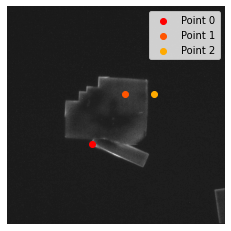

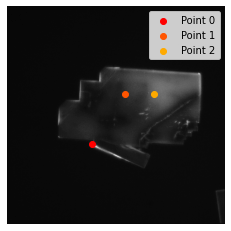

In [13]:
%matplotlib inline


plt.figure("Points location start")

image=images_2D[0].data[24][:][:] # could use better way of visualising
plt.imshow((image), cmap='Greys_r')

cmap = plt.cm.get_cmap('autumn') # use any colormap you like

for i in np.arange(len(points)):
    col = cmap(i/len(points)) # cmap takes float between 0 & 1 and returns corresponding color
    point = points[i]
    xcoord = point[0]
    ycoord = point[1]
    plt.scatter(xcoord, ycoord, color =col, label = "Point %i" %i)
plt.legend()
plt.axis("off")
plt.show()

plt.figure("Points location end")

image=images_2D[-1].data[24][:][:] # could use better way of visualising
plt.imshow((image), cmap='Greys_r')

cmap = plt.cm.get_cmap('autumn') # use any colormap you like

for i in np.arange(len(points)):
    col = cmap(i/len(points)) # cmap takes float between 0 & 1 and returns corresponding color
    point = points[i]
    xcoord = point[0]
    ycoord = point[1]
    plt.scatter(xcoord, ycoord, color =col, label = "Point %i" %i)
plt.legend()
plt.axis("off")
plt.show()

In [14]:
def extract_peak_wavelength(image_1d, wavelengths, point):
    """
    Point expected as x,y of indices even though how index into data is [y][x]
    Might consider making average of pixels nearby rather than peak from 1.
    
    I think to make work better need to make index finding better, will reduce noise I think when there are multiple. Or could replace with Gaussian location fitting?
    """
    # Extract spectra from data.
    x = point[0]
    y = point[1]
    pixel_spectra = image_1d.data[y][x]
    
    # Just basic but robust peak wavelength for now
    max_intensity = np.max(pixel_spectra)
    index = np.where(pixel_spectra == max_intensity)[0][0] # could make more refined so if multiple indices of max value can just say no peak or broad or average.
    # yeah good idea if not peak fitting.
    peak_lam = wavelengths[index]
    return peak_lam

In [15]:
peak_lam_series_for_points=[]
for point in points:
    peak_lam_series = []
    for image_1d in images_1D:
        peak_lam=extract_peak_wavelength(image_1d, wavelengths, point)
        peak_lam_series.append(peak_lam)
    peak_lam_series_for_points.append(peak_lam_series)

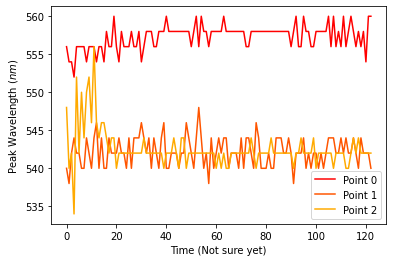

In [16]:
%matplotlib inline

cmap = plt.cm.get_cmap('autumn') # use any colormap you like

plot_indices = [0,1,2] # include indices of items want plotted

for i in np.arange(len(points)):
    if i in plot_indices:
        col = cmap(i/len(points)) # cmap takes float between 0 & 1 and returns corresponding color
        plt.plot(ts, peak_lam_series_for_points[i], color =col, label = "Point %i" %i)
plt.xlabel("Time (Not sure yet)")
plt.ylabel("Peak Wavelength ($nm$)")
plt.legend()
plt.show()

## Unsupervised Machine Learning

Select which time steps to look at.

In [38]:
selected_indices = [0, int(np.rint(len(images_1D)/2)),-1]

Perform single value decomposition.

### Single Time Step Inspection

In [52]:
im_1d=images_1D[122].copy()

In [ ]:
# 60 with 0 and N=4 good. Dodgy corner and nice peaks.
# 60 with 122 and N=4 also interesting - maybe different fast region. But not so clear with corner. COuld be more complicated than want.

Alternative if don't want to load the full time series.

In [24]:
# fpath=rectified_fpaths[0] # just looking at first image
# im_2d = hsif.extract_h5py_image_stack(fpath)
# im_1d = im_2d.transpose()

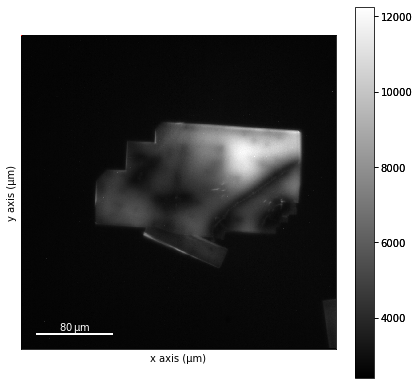

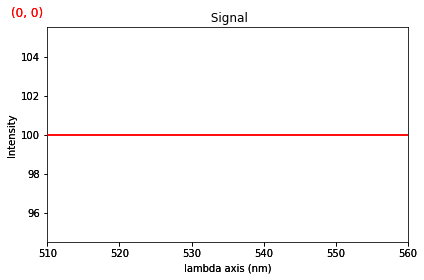

In [46]:
%matplotlib inline
im_1d.plot()

In [53]:
svd = im_1d.decomposition()

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


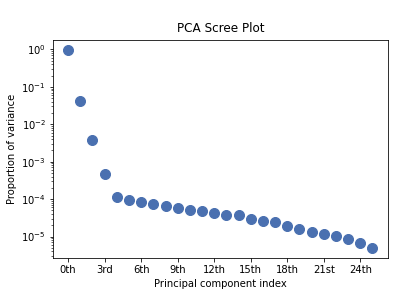

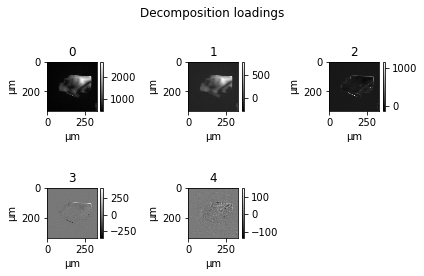

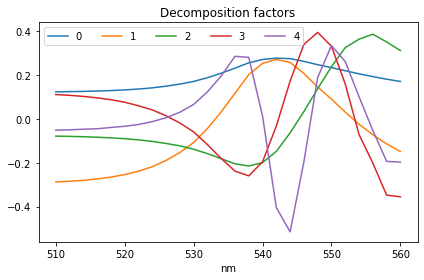

In [48]:
%matplotlib inline
im_1d.plot_explained_variance_ratio()
im_1d.plot_decomposition_loadings(comp_ids=5) # look at relevant sections of the image
im_1d.plot_decomposition_factors(comp_ids=5) # look at corresponding spectra
plt.show()

In [63]:
%matplotlib qt
plt.figure("Scree", dpi=300)
plt.plot(im_1d.get_explained_variance_ratio(), marker = '.', markersize=10, linestyle="None")
plt.yscale("log")
plt.xlabel("Principal Component Index", fontsize=10)
plt.ylabel("Proportion of Variance", fontsize=10)
plt.show()

In [64]:
N = 4
im_1d.decomposition(algorithm="NMF", output_dimension=N)

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=NMF
  output_dimension=4
  centre=None
scikit-learn estimator:
NMF(n_components=4)


In [100]:
%matplotlib qt
# set the number of components to whatever looks sensible from the scree plot
im_1d.plot_decomposition_loadings(comp_ids=N) # look at relevant sections of the image
im_1d.plot_decomposition_factors(comp_ids=N) # look at corresponding spectra
plt.show()

In [71]:
im_1d.get_decomposition_factors().data[1]

array([170.48582 , 169.39574 , 167.90948 , 165.81125 , 162.98676 ,
       159.17041 , 154.04814 , 147.32886 , 137.86601 , 126.12622 ,
       111.134766,  90.268   ,  65.78994 ,  38.87158 ,  13.008117,
         0.      ,   0.      ,   8.896053,  27.018234,  43.43352 ,
        52.980705,  59.741245,  64.98533 ,  72.71198 ,  80.66674 ,
        92.40079 ], dtype=float32)

In [101]:
%matplotlib qt
plt.figure("Decomposition Factors", dpi=300)
for i in np.arange(N):
    plt.plot(wavelengths, im_1d.get_decomposition_factors().data[i], marker = '.', markersize=10, label=i)
plt.legend(fontsize=10)
plt.xlabel("Wavelength ($nm$)", fontsize=10)
plt.ylabel("Intensity", fontsize=10)
plt.show()

In [102]:
%matplotlib qt

for i in np.arange(N):
    plt.figure("Decomposition Loading %i" %i, dpi=300)
    plt.imshow(im_1d.get_decomposition_loadings().data[i], cmap='Greys_r', vmin=0, vmax=7.4)
    plt.colorbar(label="Intensity")
    plt.axis("off")
    plt.show()
# plt.legend(fontsize=10)
# plt.xlabel("Wavelength ($nm$)", fontsize=10)
# plt.ylabel("Intensity", fontsize=10)


### Multiple Time Step Investigation

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None
Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None
Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


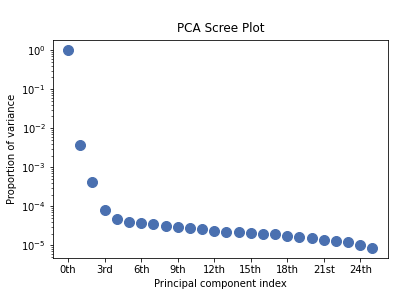

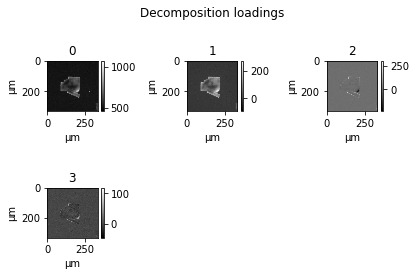

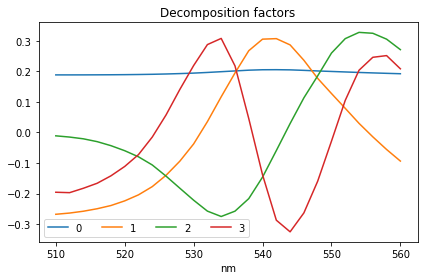

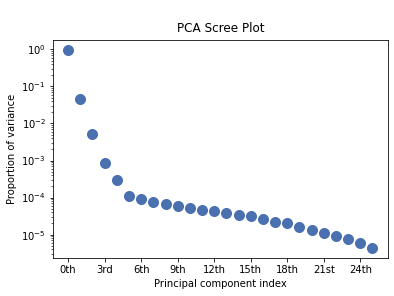

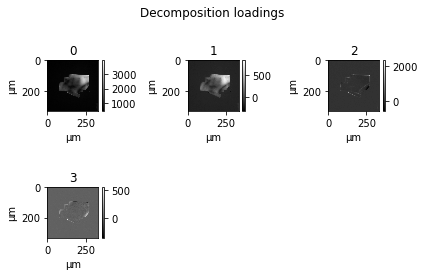

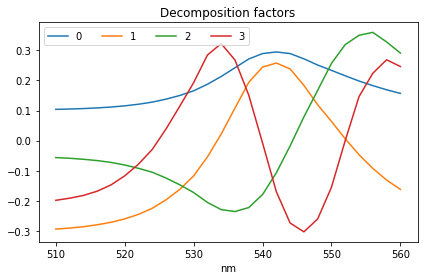

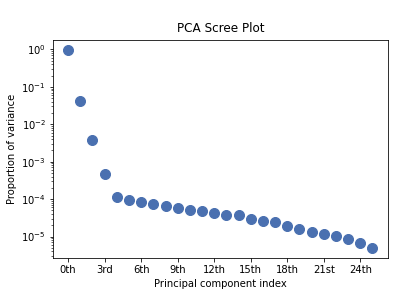

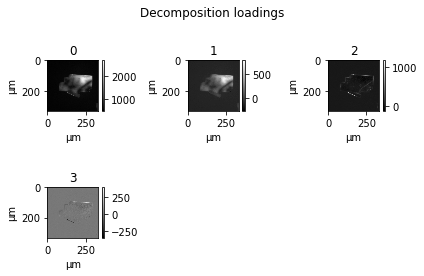

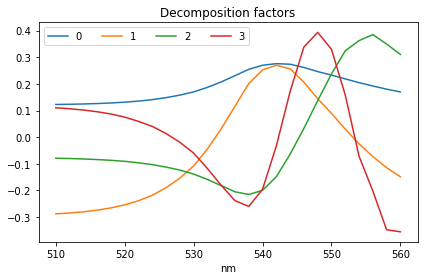

In [27]:
images_1D_copy = images_1D.copy()

significant_components = 4

for index in selected_indices:
    signal_1d = images_1D_copy[index]
    signal_1d.decomposition()
    signal_1d.plot_explained_variance_ratio()
    signal_1d.plot_decomposition_loadings(comp_ids=significant_components)
    signal_1d.plot_decomposition_factors(comp_ids=significant_components)

In [ ]:
for index in selected_indices:
    signal_1d = images_1D_copy[index]
    signal_1d.decomposition(algorithm="NMF", output_dimension=significant_components)
    signal_1d.plot_decomposition_loadings(comp_ids=significant_components)
    signal_1d.plot_decomposition_factors(comp_ids=significant_components)

In [ ]:
signal_1d.get_decomposition_factors # can do this to plot how I like.

In [ ]:
signal_1d.plot_decomposition_loadings(comp_ids=significant_components)
signal_1d.plot_decomposition_factors(comp_ids=significant_components)

In [ ]:
# want to take components on Scree before gradient changes, not including the first with new gradient. 
# so choose new number of significant for each. 
# partly guided by what expect to see, i.e. if looking for 2 or 4 components. 
